# Okumura-Hata Model

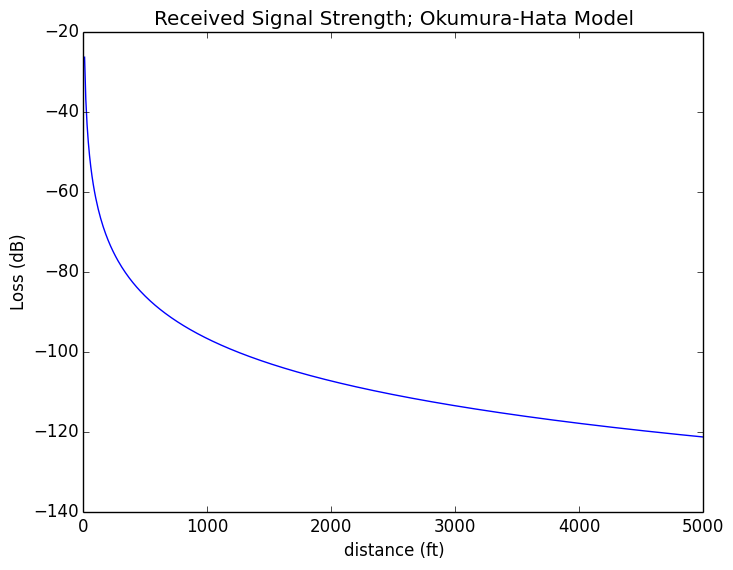

In [1]:
using PyPlot

fc = 800 # MHz
hb = 100 # ft
hm = 5.7 # ft

hb *= 0.3048
hm *= 0.3045

a = hm -> 8.28*(log10(1.54*hm))^2 - 1.1 # large city with fc >= 400 MHz
A = 69.55 + 26.16*log10(fc) - 13.82*log10(hb) - a(hm)
B = 44.9 - 6.55*log10(hb)
C = 5.4 + 2*(log10(fc/28))^2

Lp = d -> A + B * log10(d) - C # dB, suburban area

x = 10:10:5000 # ft
y = -Lp(x * 0.3048 / 1000)

plot(x, y)

title("Received Signal Strength; Okumura-Hata Model")
xlabel("distance (ft)")
ylabel("Loss (dB)")

;

In [3]:
using Roots

y = 80
f = x -> -Lp(x) - y

dist = fzero(f, 0, 5000)
dist *= 1000 * 3.281

0.009437049913395683

In [4]:
y = 80.
10^((y - A + C)/B) * 1000 * 3.281

333.35996097655305

# Trilateration

In [6]:
uav_loc = [100., 2500.]
cell_towers = Vector{Float64}[[160., 200.], [2100., 4900.], [4800., 500.]]

cell_tower_indexes = [1, 2, 3]

D = zeros(3)
    
for i in cell_tower_indexes
    d = norm(uav_loc - cell_towers[i])
    D[i] = d

    println(D[i])
end 


P1 = [cell_towers[cell_tower_indexes[1]]; 0]
P2 = [cell_towers[cell_tower_indexes[2]]; 0]
P3 = [cell_towers[cell_tower_indexes[3]]; 0]

ex = (P2 - P1) / norm(P2 - P1)
i = dot(ex, P3 - P1)
ey = (P3 - P1 - i*ex) / norm(P3 - P1 - i*ex)
ez = cross(ex, ey)
d = norm(P2 - P1)
j = dot(ey, P3 - P1)

x = (D[1]^2 - D[2]^2 + d^2) / (2 * d)
y = (D[1]^2 - D[3]^2 + i^2 + j^2) / (2 * j) - i / j * x
z = sqrt(D[1]^2 - x^2 - y^2)

p = P1 + x*ex + y*ey + z*ez

println(p)

;

2300.782475593901
3124.099870362662
5107.837115648854
[99.99999999999977,2499.9999999999995,-4.448663249851456e-5]


# UTM Simulation

In [7]:
include("simScenario.jl");

In [8]:
using PyPlot

function simulation(model, uav_indexes, navigations, headings; N = 1000, RE_threshold = 0.1, bPlot = false)
    
    srand(uint(time()))

    va = Float64[]
    y = 0.

    n = 1
    while true
        sc, sc_state = generateScenario(model, uav_indexes = uav_indexes, navigations = navigations)
        
        x = simulate(sc, sc_state, uav_indexes = 1, headings = headings)
        y += (x - y) / n
        push!(va, y)

        if n % 100 == 0
            if std(va) / va[end] < RE_threshold
                break
            end
        end

        if n == N
            break
        end

        n += 1
    end

    println("n: ", n, ", mean: ", va[end], ", std: ", std(va), ", RE: ", std(va) / va[end])
    
    if bPlot
        plot(1:n, va)
    end
end

;

In [17]:
simulation("v0.1", 1, :nav1, :Waypoint1);
simulation("v0.1", 1, :nav1, :Waypoint2);
simulation("v0.1", 1, :nav1, :End);
simulation("v0.1", 1, :nav1, :Base1);
simulation("v0.1", 1, :nav1, :Base2);
simulation("v0.1", 1, :nav1, :Base3);

n: 400, mean: 0.8750000000000001, std: 0.07497976126177379, RE: 0.08569115572774147
n: 100, mean: 1.0, std: 0.0, RE: 0.0
n: 100, mean: 1.0, std: 0.0, RE: 0.0
n: 1000, mean: 0.0, std: 0.0, RE: NaN
n: 100, mean: 1.0, std: 0.0, RE: 0.0
n: 100, mean: 0.99, std: 0.007801380803460188, RE: 0.007880182629757766


In [22]:
include("simUTMPlannerV1.jl");

In [23]:
using PyPlot

function simulation(; N = 100, RE_threshold = 0.1, bSeq = false, ts = 0, action = :None_, rollout_type = :default, bPlot = false)

    va = Float64[]
    y = 0.

    n = 1
    while true
        pm = UTMPlannerV1(seed = round(Int64, time()))

        #pm.sc.UAVs[1].navigation = :GPS_INS
        pm.sc.sa_dist = 500.

        # XXX debug
        #print(pm.seed, " ")

        if !bSeq
            x = simulate(pm, nothing, ts = ts, action = action)
        else
            alg = POMCP(depth = 5, default_policy = default_policy, nloop_max = 100, nloop_min = 100, c = 500., gamma_ = 0.95, rollout_type = rollout_type, rgamma_ = 0.95)
            x = simulate(pm, alg, bSeq = bSeq)
        end

        # XXX debug
        #println(n, " ", x)

        y += (x - y) / n
        push!(va, y)

        if n % 100 == 0
            if std(va) / abs(va[end]) < RE_threshold
                break
            end
        end

        if n == N
            break
        end

        n += 1
    end

    println("n: ", n, ", mean: ", neat(va[end]), ", std: ", neat(std(va)), ", RE: ", neat(std(va) / abs(va[end])))
    
    if bPlot
        plot(1:n, va)
    end
end;

In [5]:
simulation(action = :None_);
simulation(action = :Waypoint2);
simulation(action = :End);
simulation(action = :Base1);
simulation(action = :Base2);
simulation(action = :Base3);

n: 100, mean: -5930.0, std: 453.2, RE: 0.0764
n: 100, mean: -9726.0, std: 234.2, RE: 0.0241
n: 100, mean: -6249.0, std: 290.0, RE: 0.0464
n: 100, mean: -68.0, std: 0.0, RE: 0.0
n: 100, mean: -14930.0, std: 168.2, RE: 0.0113
n: 100, mean: -2302.0, std: 417.8, RE: 0.1815


-52.22, 26.32, -0.504


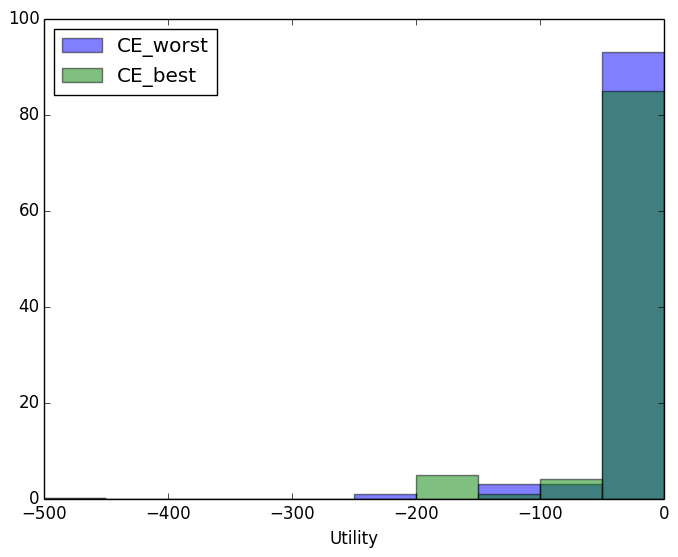

-54.44, 26.99, -0.4957


In [25]:
using PyPlot

function plot_hist(filename, label)
    
    D = readdlm(filename, ' ')
    U = map(Float64, D[1:end-1, 3])
    U = U[find(U .> -500)]
    plt[:hist](U, range = (-500, 0), alpha = 0.5, label = label)
    println(neat(mean(U)), ", ", neat(std(U)), ", ", neat(std(U)/mean(U)))
    #println(U[find(U .< -1000)])
end

plot_hist("CE_worst_1000.log", "CE_worst")
plot_hist("CE_best_1000.log", "CE_best")
xlabel("Utility")
legend(loc = "best")

;

# SparseUCT and Progressive Widening

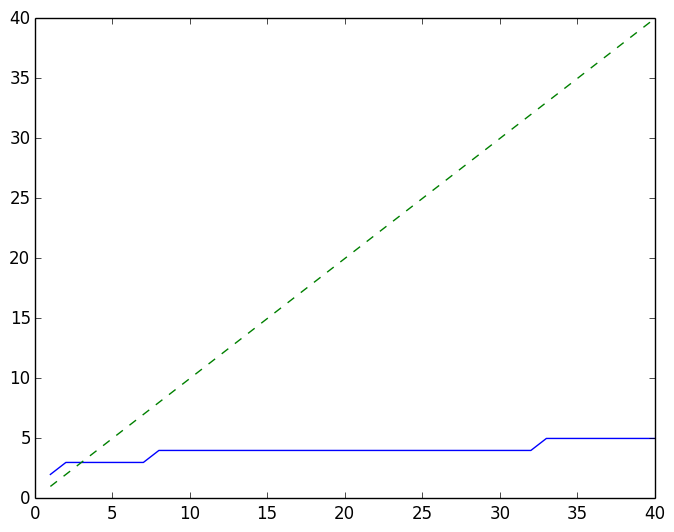

In [7]:
using PyPlot

c = 2
alpha = 0.2

n = 1:40

plot(n, ceil(c * n .^ alpha), n, n, "--")

;

In [18]:
function readData()
    
    D = Dict()

    f = open("log_ep02")

    for i = 1:11
        line = chomp(readline(f))
        sn = parse(Int64, split(line, ":")[2])
        D[sn] = Dict()
        readline(f)

        readline(f)
        D[sn]["plain"] = float64(split(split(chomp(readline(f)), ",")[2], ":")[2])
        readline(f)

        D[sn]["sparse"] = Dict()
        for nObsMax in [1, 2, 4, 6, 8, 10, 12]
            readline(f)
            D[sn]["sparse"][nObsMax] = float64(split(split(chomp(readline(f)), ",")[2], ":")[2])
        end
        readline(f)

        D[sn]["pw"] = Dict()
        D[sn]["pw"]["c"] = Dict()
        for c in [1, 2, 4, 6]
            readline(f)
            D[sn]["pw"]["c"][c] = float64(split(split(chomp(readline(f)), ",")[2], ":")[2])
        end
        readline(f)

        D[sn]["pw"]["alpha"] = Dict()
        for alpha in [0.1, 0.2, 0.4, 0.6]
            readline(f)
            D[sn]["pw"]["alpha"][alpha] = float64(split(split(chomp(readline(f)), ",")[2], ":")[2])
        end

        readline(f)
        readline(f)
    end

    close(f)
    
    return D
end


using PyPlot

function plotBest(; sn_list::Union{Int64, Vector{Int64}, Void} = nothing, y_range::Union{Vector{Float64}, Void} = nothing)
    
    D = readData()

    if sn_list == nothing
        sn_list = sort(collect(keys(D)))
    end
    
    nScenarios = length(sn_list)
    X = zeros(Int64, nScenarios)
    X_plain = zeros(Float64, nScenarios)
    X_sparse = zeros(Float64, nScenarios)
    X_pw = zeros(Float64, nScenarios)
    
    n = 0
    for sn in sn_list
        n += 1
        
        X[n] = sn

        X_plain[n] = D[sn]["plain"]

        x = -Inf
        for nObsMax in [1, 2, 4, 6, 8, 10, 12]
            if D[sn]["sparse"][nObsMax] > x
                x = D[sn]["sparse"][nObsMax]
            end
        end
        X_sparse[n] = x

        x = -Inf
        for c in [1, 2, 4, 6]
            if D[sn]["pw"]["c"][c] > x
                x = D[sn]["pw"]["c"][c]
            end
        end
        for alpha in [0.1, 0.2, 0.4, 0.6]
            if D[sn]["pw"]["alpha"][alpha] > x
                x = D[sn]["pw"]["alpha"][alpha]
            end
        end
        X_pw[n] = x
        
        println("scenario: ", X[n], ", plain: ", X_plain[n], ", sparse: ", X_sparse[n], ", pw: ", X_pw[n])
    end
    
    sleep(0.1)
    
    plot(1:n, X_plain, ".", 1:n, X_sparse, ".", 1:n, X_pw, ".")
    xlim([0, n+1])
    if y_range != nothing
        ylim(y_range)
    end
    xticks(1:n, X, rotation = "vertical")
    xlabel("scenario")
    ylabel("average utility")
    legend(["plain", "sparse", "pw"], loc = "lower left")
    
    return X, X_plain, X_sparse, X_pw
end


function plotWithParam(; sn_list::Union{Int64, Vector{Int64}, Void} = nothing, nObsMax::Int64 = 6, c::Float64 = 2, alpha::Float64 = 0.1, y_range::Union{Vector{Float64}, Void} = nothing)
    
    D = readData()
    
    if sn_list == nothing
        sn_list = sort(collect(keys(D)))
    end
    
    nScenarios = length(sn_list)
    X = zeros(Int64, nScenarios)
    X_plain = zeros(Float64, nScenarios)
    X_sparse = zeros(Float64, nScenarios)
    X_pw = zeros(Float64, nScenarios)
    
    n = 0
    for sn in sn_list
        n += 1
        
        X[n] = sn
        X_plain[n] = D[sn]["plain"]
        X_sparse[n] = D[sn]["sparse"][nObsMax]

        if alpha == 0.4
            X_pw[n] = D[sn]["pw"]["c"][c]
        else
            @assert c == 2
            X_pw[n] = D[sn]["pw"]["alpha"][alpha]
        end
        
        println("scenario: ", X[n], ", plain: ", X_plain[n], ", sparse: ", X_sparse[n], ", pw: ", X_pw[n])
    end
    
    sleep(0.1)
    
    plot(1:n, X_plain, ".", 1:n, X_sparse, ".", 1:n, X_pw, ".")
    xlim([0, n+1])
    if y_range != nothing
        ylim(y_range)
    end
    xticks(1:n, X, rotation = "vertical")
    xlabel("scenario")
    ylabel("average utility")
    legend(["plain", "sparse", "pw"], loc = "lower left")
    
    return X, X_plain, X_sparse, X_pw
end


function plotWithAllParam(param::Symbol; sn_list::Union{Int64, Vector{Int64}, Void} = nothing, y_range::Union{Vector{Float64}, Void} = nothing)
    
    D = readData()

    nScenarios = length(keys(D))
    X = Dict()
    
    if sn_list == nothing
        sn_list = sort(collect(keys(D)))
    end
    
    for sn in sn_list
        i = 1
        
        if param == :nObsMax
            X[sn] = zeros(7)
            for nObsMax in [1, 2, 4, 6, 8, 10, 12]
                X[sn][i] = D[sn]["sparse"][nObsMax]
                i += 1
            end
            
        elseif param == :c
            X[sn] = zeros(4)
            for c in [1, 2, 4, 6]
                X[sn][i] = D[sn]["pw"]["c"][c]
                i += 1
            end
        
        elseif param == :alpha
            X[sn] = zeros(4)
            for alpha in [0.1, 0.2, 0.4, 0.6]
                X[sn][i] = D[sn]["pw"]["alpha"][alpha]
                i += 1
            end
            
        end
        
        println("scenario: ", sn, ", ", X[sn])
        
        sleep(0.1)
        
        plot(1:length(X[sn]), X[sn])
    end
    
    if y_range != nothing
        ylim(y_range)
    end
    
    if param == :nObsMax
        xlim([0, 8])
        xticks(1:7, [1, 2, 4, 6, 8, 10, 12])
        xlabel("nObsMax")
    elseif param == :c
        xlim([0, 5])
        xticks(1:4, [1, 2, 4, 6])
        xlabel("c")
    elseif param == :alpha
        xlim([0, 5])
        xticks(1:4, [0.1, 0.2, 0.4, 0.6])
        xlabel("alpha")
        
    end
    
    ylabel("average utility")
    
    return X
end


;

scenario: 1, plain: -1193.0, sparse: -50.7, pw: -61.97
scenario: 2142, plain: -223.1, sparse: -37.0, pw: -36.0
scenario: 8440, plain: -5170.0, sparse: -3550.0, pw: -3117.0
scenario: 15084, plain: -8895.0, sparse: -3984.0, pw: -4792.0
scenario: 31656, plain: -796.9, sparse: -153.1, pw: -248.6


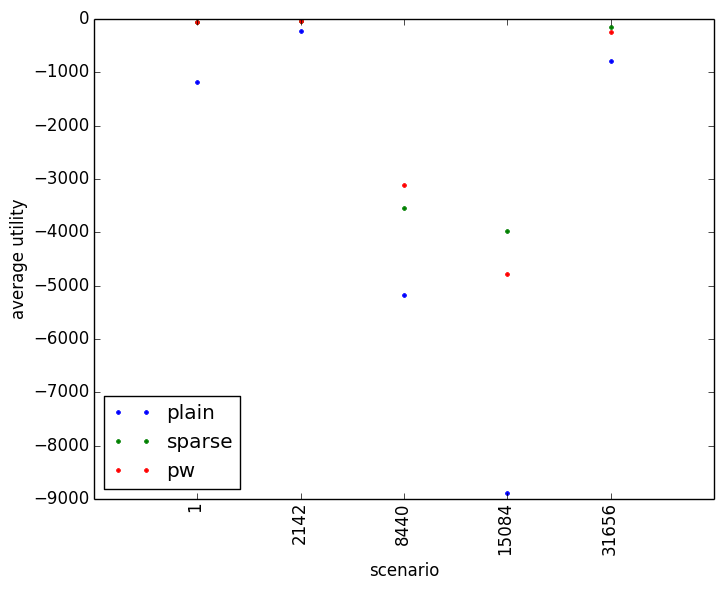

In [15]:
# 1, 1161, 1250, 1785, 2142, 2620, 8440, 9525, 12506, 15084, 31656
# 1, 2142, 8440, 15084, 31656
#plotBest();
plotBest(sn_list = [1, 2142, 8440, 15084, 31656]);

scenario: 1, plain: -1193.0, sparse: -50.7, pw: -65.57
scenario: 2142, plain: -223.1, sparse: -37.0, pw: -36.4
scenario: 8440, plain: -5170.0, sparse: -3734.0, pw: -3117.0
scenario: 15084, plain: -8895.0, sparse: -5356.0, pw: -5298.0
scenario: 31656, plain: -796.9, sparse: -369.3, pw: -485.4


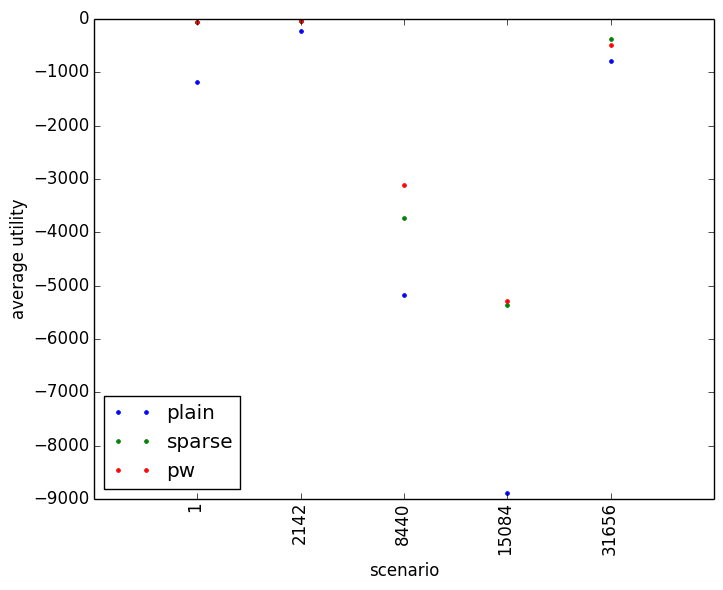

In [16]:
# 1, 1161, 1250, 1785, 2142, 2620, 8440, 9525, 12506, 15084, 31656
# 1, 2142, 8440, 15084, 31656
#plotWithParam(nObsMax = 8, c = 2., alpha = 0.4);
plotWithParam(sn_list = [1, 2142, 8440, 15084, 31656], nObsMax = 8, c = 2., alpha = 0.4);

scenario: 1, [-2690.0,-857.2,-176.8,-64.7,-50.7,-483.2,-135.7]
scenario: 2142, [-148.3,-86.65,-65.86,-75.46,-37.0,-37.2,-53.61]
scenario: 8440, [-5838.0,-5400.0,-4588.0,-4625.0,-3734.0,-3550.0,-3663.0]
scenario: 15084, [-4748.0,-5016.0,-5743.0,-6450.0,-5356.0,-3984.0,-5815.0]
scenario: 31656, [-1462.0,-762.1,-1155.0,-485.9,-369.3,-153.1,-624.5]


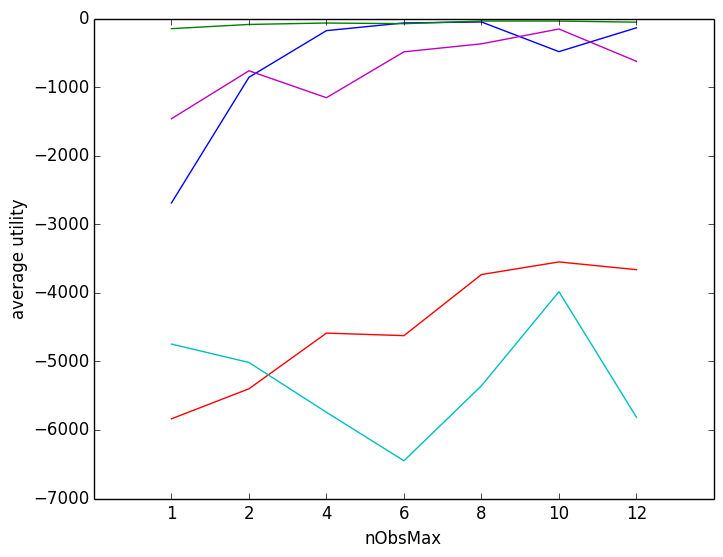

In [19]:
# 1, 1161, 1250, 1785, 2142, 2620, 8440, 9525, 12506, 15084, 31656
#plotWithAllParam(:nObsMax);
#plotWithAllParam(:c);
#plotWithAllParam(:c, y_range = [-1000., 100.]);
#plotWithAllParam(:alpha);
#plotWithAllParam(:alpha, y_range = [-1000., 100.]);

# 1, 2142, 8440, 15084, 31656
plotWithAllParam(:nObsMax, sn_list = [1, 2142, 8440, 15084, 31656]);
#plotWithAllParam(:c, sn_list = [1, 2142, 8440, 15084, 31656]);
#plotWithAllParam(:alpha, sn_list = [1, 2142, 8440, 15084, 31656]);

plainUCT  
&nbsp;&nbsp;&nbsp;&nbsp;$\overline{Q}(h,a) + c \times \sqrt{\frac{\ln{N(h)}}{N(h,a)}}$, $c = \sqrt{2}$

SparseUCT  
&nbsp;&nbsp;&nbsp;&nbsp;$|o| <= nObsMax$ in belief tree, $nObsMax = 8$

UCB1-tuned  
&nbsp;&nbsp;&nbsp;&nbsp;$\overline{Q}(h,a) + \sqrt{\frac{\ln{N(h)}}{N(h,a)} \min ( \frac{1}{4}, \text{Var}(h,a) + \sqrt{\frac{2\ln{N(h)}}{N(h,a)}} )}$

UCB-V  
&nbsp;&nbsp;&nbsp;&nbsp;$\overline{Q}(h,a) + \sqrt{\frac{2 \text{Var}(h,a) \ln{N(h)}}{N(h,a)}} + c \times \frac{3 \ln{N(h)}}{N(h,a)}$, $c = 1$

MSUCT: UCT + Multilevel Splitting  
&nbsp;&nbsp;&nbsp;&nbsp;generate more branches based on distance (level)  
&nbsp;&nbsp;&nbsp;&nbsp;bias tree expansion toward collisions


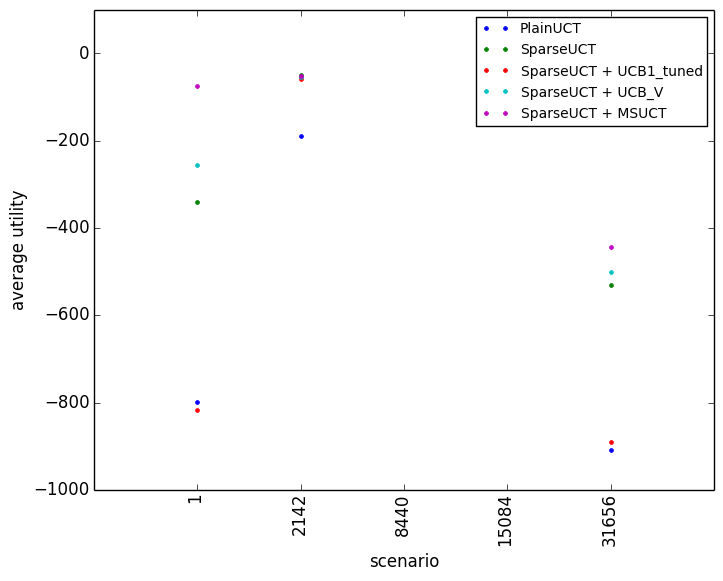

In [20]:
using PyPlot

n = 5
X = [1, 2142, 8440, 15084, 31656]
X_pl = [-799.8, -190.1, -5559.0, -8895.0, -908.0] # plainUCT
X_sp = [-340.8, -48.91, -4171.0, -5489.0, -530.6] # SparseUCT
X_ut = [-816.7, -59.16, -5121.0, -6136.0, -891.4] # SparseUCT + UCB1_tuned
X_uv = [-254.7, -54.27, -2539.0, -3842.0, -501.3] # SparseUCT + UCB_V
X_ms = [-74.91, -50.97, -3745.0, -4634.0, -442.6] # SparseUCT + MSUCT

plot(1:n, X_pl, ".", 1:n, X_sp, ".", 1:n, X_ut, ".", 1:n, X_uv, ".", 1:n, X_ms, ".")
xlim([0, n+1])
ylim([-1000, 100])
xticks(1:n, X, rotation = "vertical")
xlabel("scenario")
ylabel("average utility")
legend(["PlainUCT", "SparseUCT", "SparseUCT + UCB1_tuned", "SparseUCT + UCB_V", "SparseUCT + MSUCT"], fontsize = "small", loc = "best")
savefig("Figure1.png")

;